In [1]:
import numpy as np
import warnings
import itertools
import pandas as pd
import os
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
%matplotlib inline

In [2]:
cnx = mysql.connector.connect(user = "n.neshat",
                                         passwd = "Start123", 
                                         db = "base",
                                         host="192.168.126.29")
cursor = cnx.cursor()

user = """
SELECT 
    DATE_FORMAT(created_at, '%Y-%m') as date,
    COUNT(id) as count
FROM
    base.projects

GROUP BY DATE_FORMAT(created_at, '%Y-%m')
Order BY DATE_FORMAT(created_at, '%Y-%m') asc 
    """

cursor.execute(user)

myresult = cursor.fetchall()

In [3]:
df =pd.DataFrame(myresult, columns=[x[0] for x in cursor.description])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    47 non-null     object
 1   count   47 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 880.0+ bytes


In [5]:
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
df.head()

,count
date,
2017-04-01,4
2017-05-01,2
2017-07-01,4
2017-08-01,9
2017-09-01,6


[Text(0.5, 0, 'Dates'), Text(0, 0.5, 'Total projects count')]

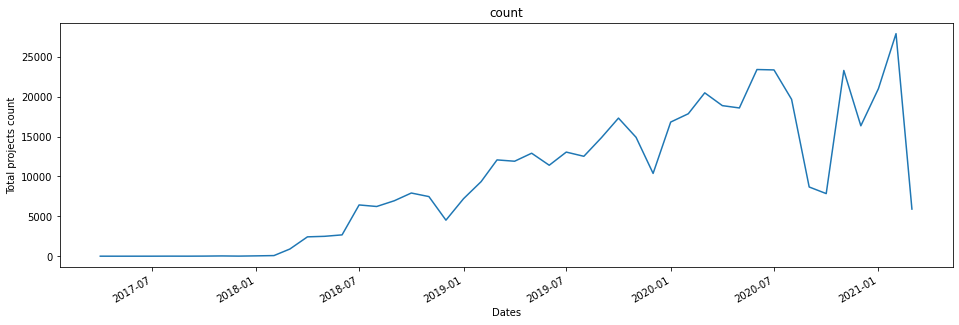

In [6]:
df.asfreq('MS').index
ax = df['count'].plot(figsize = (16,5), title = "count")
ax.set(xlabel='Dates', ylabel='Total projects count')

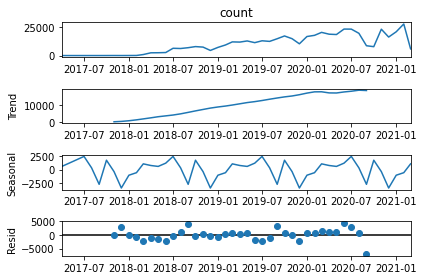

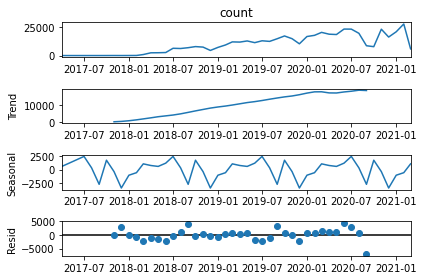

In [7]:
a = seasonal_decompose(df["count"], model = "add",  freq=12)
a.plot()

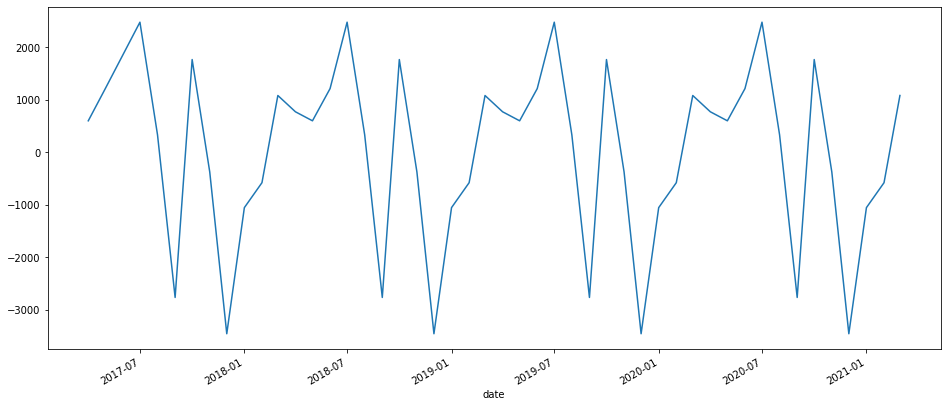

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0,2)

# Generate all different combinations of p, q and q triplets

pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')

print('Sarimax: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('Sarimax: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('Sarimax: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('Sarimax: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
Sarimax: (0, 0, 1) x (0, 0, 1, 12)
Sarimax: (0, 0, 1) x (0, 1, 0, 12)
Sarimax: (0, 1, 0) x (0, 1, 1, 12)
Sarimax: (0, 1, 0) x (1, 0, 0, 12)


In [10]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1002.9720854631452
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1526.9804921588254
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:711.8248836817426
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:449.101817845004
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:728.3575717178165
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1346.4014927515404
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:476.30776686173203
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:450.9981274400138
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:952.7483365523383
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2815.8875326127472
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:675.9844484773499
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:433.5351716075718
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:738.1420667343621
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2559.905332072461
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:475.66630906864475
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:435.4934400296275
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:896.9161705524494
SARIMAX(0, 1, 0)x(0, 0, 1,

In [11]:
df[:len(df)-12]
df[len(df)-12:]

train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [12]:
arima_model = SARIMAX(df['count'], order = (0, 1, 1), seasonal_order = (0, 1, 1, 12))
                      
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              count   No. Observations:                   47
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -341.461
Date:                            Thu, 11 Mar 2021   AIC                            688.923
Time:                                    11:47:41   BIC                            693.502
Sample:                                         0   HQIC                           690.484
                                             - 47                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7395      0.154     -4.810      0.000      -1.041      -0.438
ma.S.L12      -0.5440      0.350     -1.553      0.120      -1.230       0.142
sigma2      3.937e+07   1.46e-08   2.69e+15      0.000    3.94e+07    3.94e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                53.35
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               9.80   Skew:                            -2.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.02e+31. Standard errors may be unstable.
"""

In [13]:
arima_pred = arima_result.predict(start = len(train_data), end = len(df)-1, typ="levels").rename("ARIMA Predictions")
arima_pred

date
2020-04-01    19127.508331
2020-05-01    19577.127768
2020-06-01    18665.712469
2020-07-01    21673.114848
2020-08-01    21826.725260
2020-09-01    22549.375557
2020-10-01    20332.442072
2020-11-01    15842.980977
2020-12-01    14909.537165
2021-01-01    19013.667730
2021-02-01    20607.218213
2021-03-01    24599.046434
Name: ARIMA Predictions, dtype: float64

In [14]:
arima_model = SARIMAX(df['count'], order = (0,0,1), seasonal_order = (0,1,0,12))
arima_result = arima_model.fit()
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               count   No. Observations:                   47
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                -353.648
Date:                             Thu, 11 Mar 2021   AIC                            711.297
Time:                                     11:47:41   BIC                            714.407
Sample:                                          0   HQIC                           712.370
                                              - 47                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8888      0.104      8.561      0.000       0.685       1.092
sigma2      3.475e+07   5.48e-10   6.35e+16      0.000    3.48e+07    3.48e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):               113.79
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                            -2.41
Prob(H) (two-sided):                  0.05   Kurtosis:                        10.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.32e+32. Standard errors may be unstable.
"""

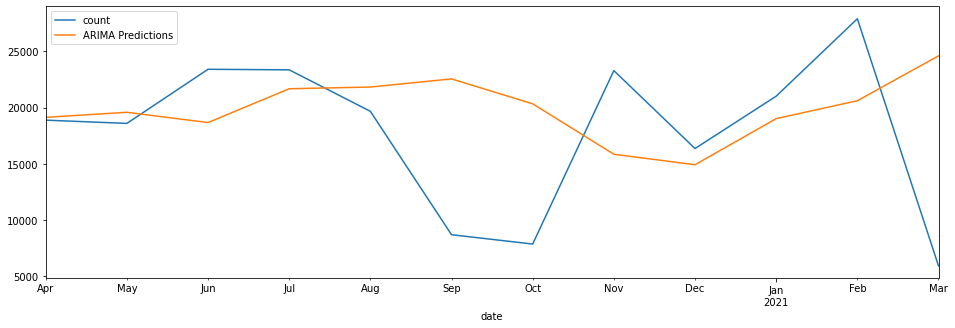

In [15]:
test_data['count'].plot(figsize = (16,5), legend=True)
arima_pred.plot(legend = True);

In [16]:
arima_rmse_error = rmse(test_data['count'], arima_pred)
arima_mse_error = arima_rmse_error**2
mean_value = df['count'].mean()

print(f'MSE Error: {arima_mse_error}\nRMSE Error: {arima_rmse_error}\nMean: {mean_value}')

MSE Error: 70268404.83891065
RMSE Error: 8382.625175856943
Mean: 9919.574468085106


In [85]:
test_data['ARIMA_Predictions'] = arima_pred

In [63]:
df[:len(df)-12]
df[len(df)-12:]

train_data = df[:len(df)-12]
test_data = df[len(df)-12:]

In [64]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [65]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [94]:
lstm_model.fit_generator(generator,epochs=68)

Epoch 1/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 2/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0070
Epoch 3/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0066
Epoch 4/68
23/23 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 5/68
23/23 [==============================] - 0s 6ms/step - loss: 0.0055
Epoch 6/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 7/68
23/23 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 8/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 9/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0059
Epoch 10/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 11/68
23/23 [==============================] - 0s 7ms/step - loss: 0.0062
Epoch 12/68
23/23 [==============================] - 0s 6ms/step - loss: 0.0066
Epoch 13/68
23/23 [==============================

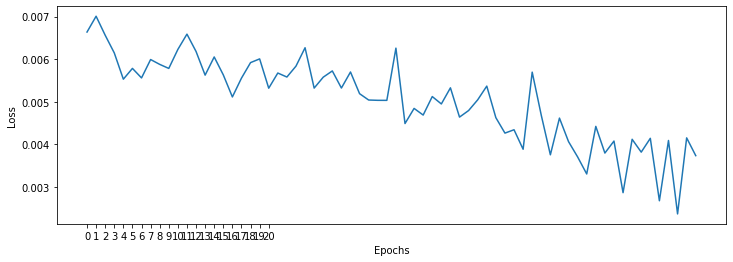

In [95]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [96]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [97]:
lstm_predictions_scaled

[array([1.0332314], dtype=float32),
 array([1.0700598], dtype=float32),
 array([1.0234622], dtype=float32),
 array([1.0840464], dtype=float32),
 array([1.0728875], dtype=float32),
 array([1.1441255], dtype=float32),
 array([1.2007248], dtype=float32),
 array([1.1395311], dtype=float32),
 array([1.0556813], dtype=float32),
 array([1.1833171], dtype=float32),
 array([1.1968572], dtype=float32),
 array([1.221972], dtype=float32)]

In [98]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
lstm_predictions

array([[21164.64507604],
       [21918.9643383 ],
       [20964.55229545],
       [22205.43762398],
       [21976.88259149],
       [23435.97770405],
       [24595.24617624],
       [23341.87671852],
       [21624.4653666 ],
       [24238.70013022],
       [24516.02945662],
       [25030.4302721 ]])

In [99]:
test_data['LSTM_Predictions'] = lstm_predictions

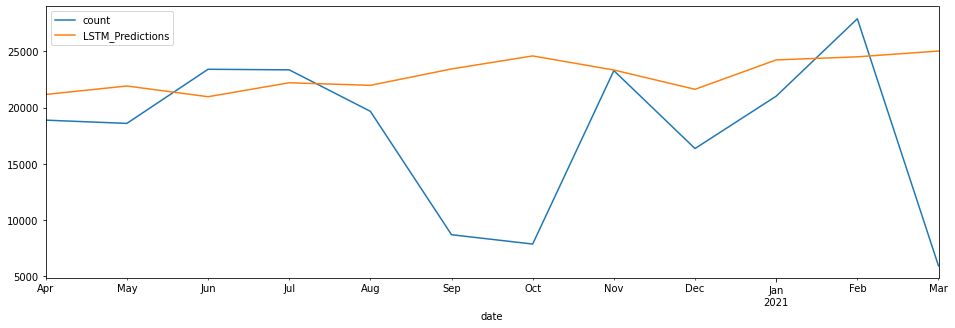

In [100]:
test_data['count'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);

In [101]:
lstm_rmse_error = rmse(test_data['count'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = df['count'].mean()

print(f'MSE Error: {lstm_mse_error}\nRMSE Error: {lstm_rmse_error}\nMean: {mean_value}')

MSE Error: 78528853.25484845
RMSE Error: 8861.650707111427
Mean: 9919.574468085106


In [102]:
df_pr = df.copy()
df_pr = df.reset_index()

df_pr.columns = ['ds','y'] # To use prophet column names should be like thattrain_data_pr = df_pr.iloc[:len(df)-12]

test_data_pr = df_pr.iloc[:len(df)-12:]
train_data_pr = df_pr.iloc[len(df)-12:]

#from fbprophet import Prophetm 
from fbprophet import Prophet

m= Prophet()
m.fit(train_data_pr)
future = m.make_future_dataframe(periods=6,freq='MS')
prophet_pred = m.predict(future)
prophet_pred.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
13,2021-05-01,15335.648355,6767.000239,23150.901533,15335.648301,15335.648407,0.0,0.0,0.0,0.0,0.0,0.0,15335.648355
14,2021-06-01,14984.954082,6929.913650,23394.218147,14984.953976,14984.954184,0.0,0.0,0.0,0.0,0.0,0.0,14984.954082
15,2021-07-01,14645.572528,5838.804786,22660.517035,14645.572369,14645.572683,0.0,0.0,0.0,0.0,0.0,0.0,14645.572528
16,2021-08-01,14294.878256,6148.432483,22717.526451,14294.878027,14294.878472,0.0,0.0,0.0,0.0,0.0,0.0,14294.878256
17,2021-09-01,13944.183984,5338.249552,22203.720451,13944.183666,13944.184275,0.0,0.0,0.0,0.0,0.0,0.0,13944.183984


In [103]:
prophet_pred = pd.DataFrame({"Date" : prophet_pred[-12:]['ds'], "Pred" : prophet_pred[-12:]["yhat"]})
prophet_pred = prophet_pred.set_index("Date")
prophet_pred.index.freq = "MS"
prophet_pred

,Pred
Date,
2020-10-01,17733.944667
2020-11-01,17383.250395
2020-12-01,17043.868842
2021-01-01,16693.174570
2021-02-01,16342.480298
2021-03-01,16025.724181
2021-04-01,15675.029908
2021-05-01,15335.648355
2021-06-01,14984.954082


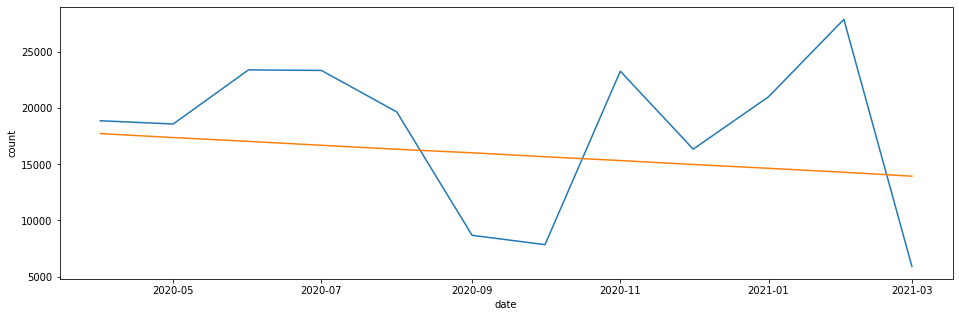

In [104]:
test_data["Prophet_Predictions"] = prophet_pred['Pred'].values
test_data["Prophet_Predictions"]
import seaborn as sns
plt.figure(figsize=(16,5))
ax = sns.lineplot(x= test_data.index, y=test_data["count"])
sns.lineplot(x=test_data.index, y = test_data["Prophet_Predictions"]);

In [105]:
prophet_rmse_error = rmse(test_data['count'], test_data["Prophet_Predictions"])
prophet_mse_error = prophet_rmse_error**2
mean_value = df['count'].mean()

print(f'MSE Error: {prophet_mse_error}\nRMSE Error:{prophet_rmse_error}\nMean:{mean_value}')


MSE Error: 47442281.62506094
RMSE Error:6887.835772219089
Mean:9919.574468085106


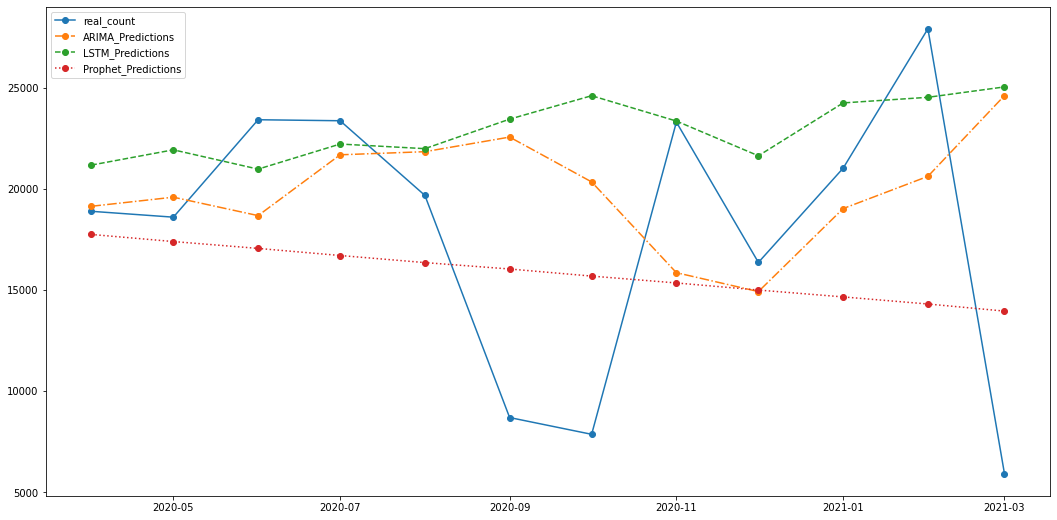

In [106]:
rmse_errors = [arima_rmse_error, lstm_rmse_error, prophet_rmse_error]
mse_errors = [arima_mse_error, lstm_mse_error, prophet_mse_error]
errors = pd.DataFrame({"Models" : ["ARIMA", "LSTM", "Prophet"],"RMSE Errors" : rmse_errors, "MSE Errors" : mse_errors})
plt.figure(figsize=(18,9))
plt.plot_date(test_data.index, test_data["count"], linestyle="-",label='real_count')
plt.plot_date(test_data.index, test_data["ARIMA_Predictions"], linestyle="-.",label='ARIMA_Predictions')
plt.plot_date(test_data.index, test_data["LSTM_Predictions"], linestyle="--",label='LSTM_Predictions')
plt.plot_date(test_data.index, test_data["Prophet_Predictions"], linestyle=":",label='Prophet_Predictions')

plt.legend()
plt.show()

In [107]:
print(f"Mean: {test_data['count'].mean()}")
errors

Mean: 17908.0


,Models,RMSE Errors,MSE Errors
0,ARIMA,8382.625176,7.026840e+07
1,LSTM,8861.650707,7.852885e+07
2,Prophet,6887.835772,4.744228e+07


In [108]:
test_data

,count,LSTM_Predictions,Prophet_Predictions,ARIMA_Predictions
date,,,,
2020-04-01,18879,21164.645076,17733.944667,19127.508331
2020-05-01,18589,21918.964338,17383.250395,19577.127768
2020-06-01,23407,20964.552295,17043.868842,18665.712469
2020-07-01,23357,22205.437624,16693.174570,21673.114848
2020-08-01,19666,21976.882591,16342.480298,21826.725260
2020-09-01,8680,23435.977704,16025.724181,22549.375557
2020-10-01,7851,24595.246176,15675.029908,20332.442072
2020-11-01,23290,23341.876719,15335.648355,15842.980977
2020-12-01,16351,21624.465367,14984.954082,14909.537165
